In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings(action = 'ignore')

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_data/myself_project/Retail_Data_Transactions.csv')
df1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project_data/myself_project/Retail_Data_Response.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


## 1. 결측치는 없는 것으로 보이고, trans_date는 객체로 나타나기 때문에 datetime 형식으로 전환해주겠음.

In [5]:
df['trans_date'] = pd.to_datetime(df['trans_date']) #object to datetime
df = df.sort_values('trans_date') # 날짜순 정렬
df

,customer_id,trans_date,tran_amount
56171,CS3366,2011-05-16,77
77394,CS4165,2011-05-16,97
2548,CS1849,2011-05-16,79
57968,CS4432,2011-05-16,41
80045,CS5573,2011-05-16,93
...,...,...,...
98929,CS4478,2015-03-16,87
38660,CS4481,2015-03-16,100
46124,CS5665,2015-03-16,38
117623,CS8141,2015-03-16,64


## 2. Frequency(빈도) 전처리

In [6]:
frequency = pd.DataFrame(df['customer_id'].value_counts()).reset_index().rename(columns = {'index': 'customer_id', 'customer_id': 'F'})
frequency

,customer_id,F
0,CS4424,39
1,CS4320,38
2,CS3799,36
3,CS3013,35
4,CS3805,35
...,...,...
6884,CS8504,4
6885,CS7224,4
6886,CS7333,4
6887,CS7716,4


## 3. Recency(최근성) 전처리

In [7]:
df = df.sort_values(['customer_id','trans_date'], ascending=False)
recency = df.drop_duplicates('customer_id')
recency = recency.drop('tran_amount', axis = 1)
recency = recency.rename(columns = {'trans_date' : 'R'})
recency

,customer_id,R
113705,CS9000,2015-02-28
114473,CS8999,2014-07-02
116764,CS8998,2014-12-22
107814,CS8997,2014-06-28
114630,CS8996,2014-12-09
...,...,...
12360,CS1116,2014-08-25
87202,CS1115,2015-03-05
2850,CS1114,2015-02-12
58038,CS1113,2015-02-09


In [8]:
pd.DataFrame(df['trans_date'].value_counts()).reset_index().sort_values('index')

,index,trans_date
888,2011-05-16,85
1062,2011-05-17,81
526,2011-05-18,93
901,2011-05-19,85
381,2011-05-20,96
...,...,...
1227,2015-03-12,77
878,2015-03-13,85
1149,2015-03-14,79
136,2015-03-15,104


### 확인해보니 2015년 3월 16일이 가장 최근 날짜이기 떄문에, 기준날짜를 2015-03-30로 설정하겠음.

In [9]:
recency['base'] = '2015-03-30'
recency['base'] = pd.to_datetime(recency['base'])
recency

,customer_id,R,base
113705,CS9000,2015-02-28,2015-03-30
114473,CS8999,2014-07-02,2015-03-30
116764,CS8998,2014-12-22,2015-03-30
107814,CS8997,2014-06-28,2015-03-30
114630,CS8996,2014-12-09,2015-03-30
...,...,...,...
12360,CS1116,2014-08-25,2015-03-30
87202,CS1115,2015-03-05,2015-03-30
2850,CS1114,2015-02-12,2015-03-30
58038,CS1113,2015-02-09,2015-03-30


In [10]:
recency['R'] = recency['base'] - recency['R']
recency = recency.drop('base', axis = 1)
recency['R'] = pd.to_numeric(recency['R']) / 10000000000000
recency


,customer_id,R
113705,CS9000,259.20
114473,CS8999,2341.44
116764,CS8998,846.72
107814,CS8997,2376.00
114630,CS8996,959.04
...,...,...
12360,CS1116,1874.88
87202,CS1115,216.00
2850,CS1114,397.44
58038,CS1113,423.36


## 4. Monetary(누적 결제 금액) 전처리

In [11]:
monetary = pd.DataFrame(df.groupby('customer_id').tran_amount.sum()).reset_index()
monetary = monetary.rename(columns = {'tran_amount': 'M'})
monetary

,customer_id,M
0,CS1112,1012
1,CS1113,1490
2,CS1114,1432
3,CS1115,1659
4,CS1116,857
...,...,...
6884,CS8996,582
6885,CS8997,543
6886,CS8998,624
6887,CS8999,383


In [12]:
rf = pd.merge(recency, frequency, how = 'inner', on = 'customer_id')
rfm = pd.merge(rf, monetary, how = 'inner', on = 'customer_id')
rfm

,customer_id,R,F,M
0,CS9000,259.20,13,533
1,CS8999,2341.44,12,383
2,CS8998,846.72,13,624
3,CS8997,2376.00,14,543
4,CS8996,959.04,13,582
...,...,...,...,...
6884,CS1116,1874.88,13,857
6885,CS1115,216.00,22,1659
6886,CS1114,397.44,19,1432
6887,CS1113,423.36,20,1490


In [13]:
rfm.describe()

,R,F,M
count,6889.000000,6889.000000,6889.000000
mean,816.810475,18.144869,1179.269705
std,737.705022,5.193014,465.832609
min,120.960000,4.000000,149.000000
25%,311.040000,14.000000,781.000000
50%,578.880000,18.000000,1227.000000
75%,1080.000000,22.000000,1520.000000
max,7525.440000,39.000000,2933.000000


In [50]:
# stand = StandardScaler()
stand = MinMaxScaler()
rfm[['R', 'F', 'M']] = stand.fit_transform(rfm[['R', 'F', 'M']]) # 표준화 실시

rfm

,customer_id,R,F,M
0,CS9000,0.018670,0.257143,0.137931
1,CS8999,0.299883,0.228571,0.084052
2,CS8998,0.098016,0.257143,0.170618
3,CS8997,0.304551,0.285714,0.141523
4,CS8996,0.113186,0.257143,0.155532
...,...,...,...,...
6884,CS1116,0.236873,0.257143,0.254310
6885,CS1115,0.012835,0.514286,0.542385
6886,CS1114,0.037340,0.428571,0.460848
6887,CS1113,0.040840,0.457143,0.481681


## 5. K-Means 실시

In [51]:
sse_ = []

for k in range(2, 20):
    kmeans = KMeans(n_clusters=k).fit(rfm[['R', 'F', 'M']])
    sse_.append([k, silhouette_score(rfm[['R', 'F', 'M']], kmeans.labels_)])

In [52]:
for i in sse_:
    print(i)

[2, 0.4663118759884504]
[3, 0.38832697126802834]
[4, 0.38698805313530765]
[5, 0.3471901254558405]
[6, 0.3553315974878768]
[7, 0.32436924158775965]
[8, 0.3043714471216931]
[9, 0.30894570637688346]
[10, 0.31287251311311937]
[11, 0.2894054527896653]
[12, 0.30290336795541056]
[13, 0.3032682913653499]
[14, 0.2939428796284896]
[15, 0.29504791961508187]
[16, 0.29386117757445596]
[17, 0.2961012969611131]
[18, 0.2968961842929222]
[19, 0.2933161422814781]


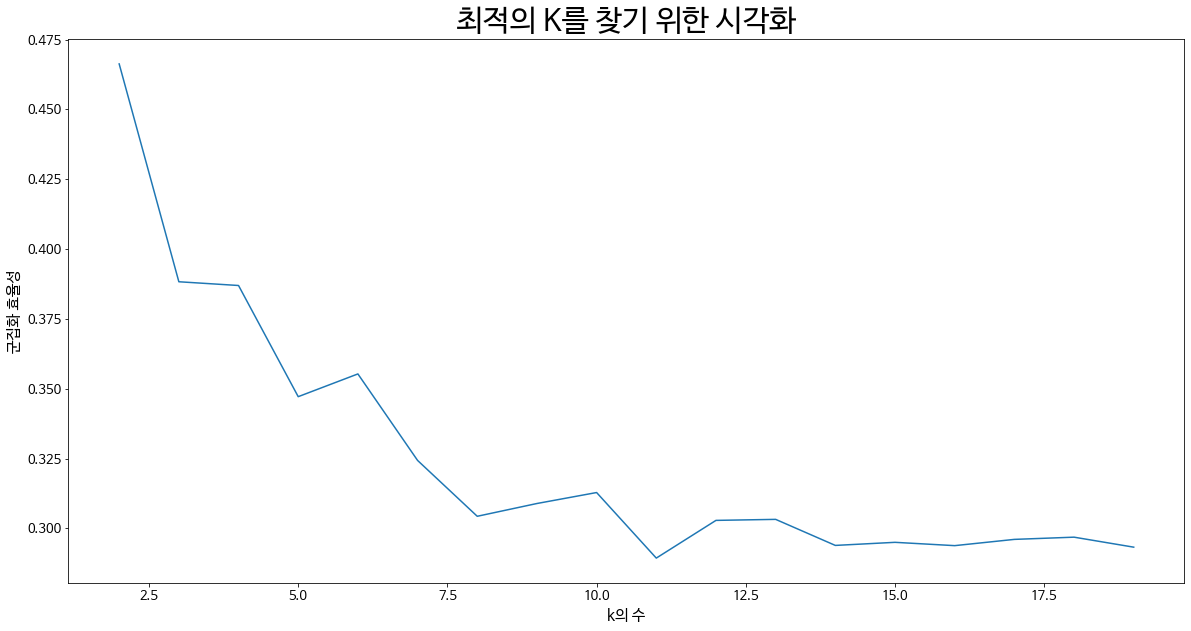

In [53]:
plt.figure(figsize = (20, 10))
plt.rc('font', family='NanumBarunGothic') 
plt.xlabel('k의 수',fontsize = 15)
plt.ylabel('군집화 효율성', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('최적의 K를 찾기 위한 시각화', fontsize = 30)
plt.plot(pd.DataFrame(sse_)[0], pd.DataFrame(sse_)[1])

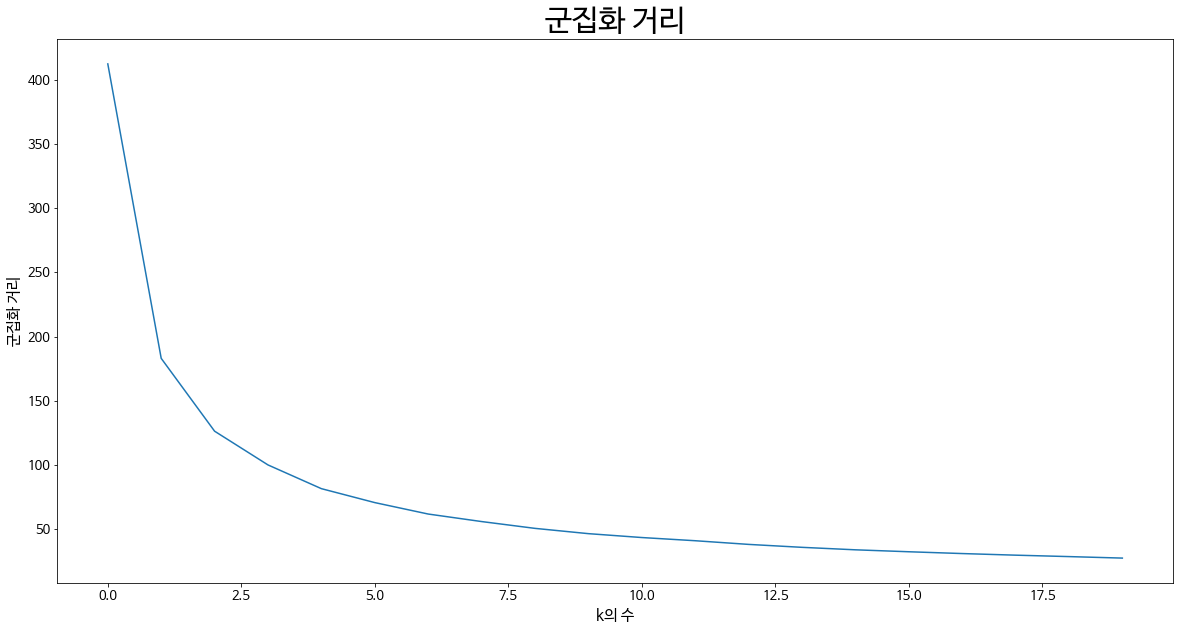

In [54]:
plt.figure(figsize = (20, 10))
plt.rc('font', family='NanumBarunGothic') 
plt.xlabel('k의 수',fontsize = 15)
plt.ylabel('군집화 거리', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title('군집화 거리', fontsize = 30)

# sum of squared distances
ssd = []
for num_clusters in list(range(1,21)):
    model_clus = KMeans(n_clusters = num_clusters, max_iter=50)
    model_clus.fit(rfm[['R', 'F', 'M']],)
    ssd.append(model_clus.inertia_)

plt.plot(ssd)

In [55]:
clus2 = KMeans(n_clusters = 2, max_iter = 50)
clus2.fit(rfm[['R', 'F', 'M']])

clus3 = KMeans(n_clusters = 3, max_iter = 50)
clus3.fit(rfm[['R', 'F', 'M']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [56]:
rfm_clus2 =pd.concat([rfm, pd.DataFrame(clus2.labels_, columns = ['label'])], axis = 1)
rfm_clus3 =pd.concat([rfm, pd.DataFrame(clus3.labels_, columns = ['label'])], axis = 1)

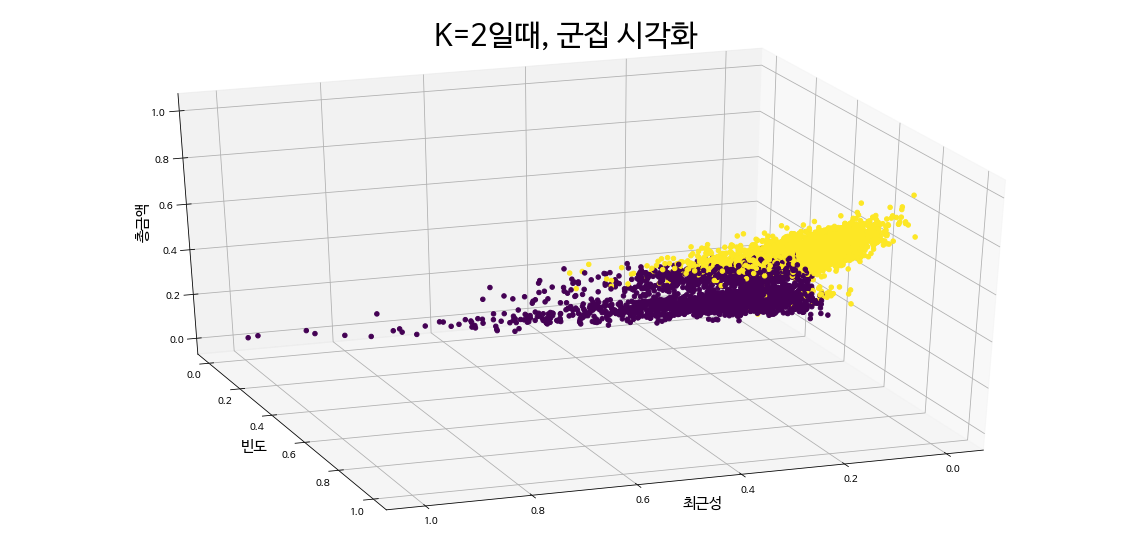

In [57]:
%matplotlib inline
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection = '3d')

x = rfm_clus2['R']
y = rfm_clus2['F']
z = rfm_clus2['M']
h = rfm_clus2['label']

ax.view_init(30, 70)
plt.title('K=2일때, 군집 시각화', fontsize = 30)
ax.set_xlabel('최근성', fontsize = 15)
ax.set_ylabel('빈도', fontsize = 15)
ax.set_zlabel('총금액', fontsize = 15, rotation = 90)
ax.scatter(x, y, z, c = h, marker = 'o', alpha = 1)

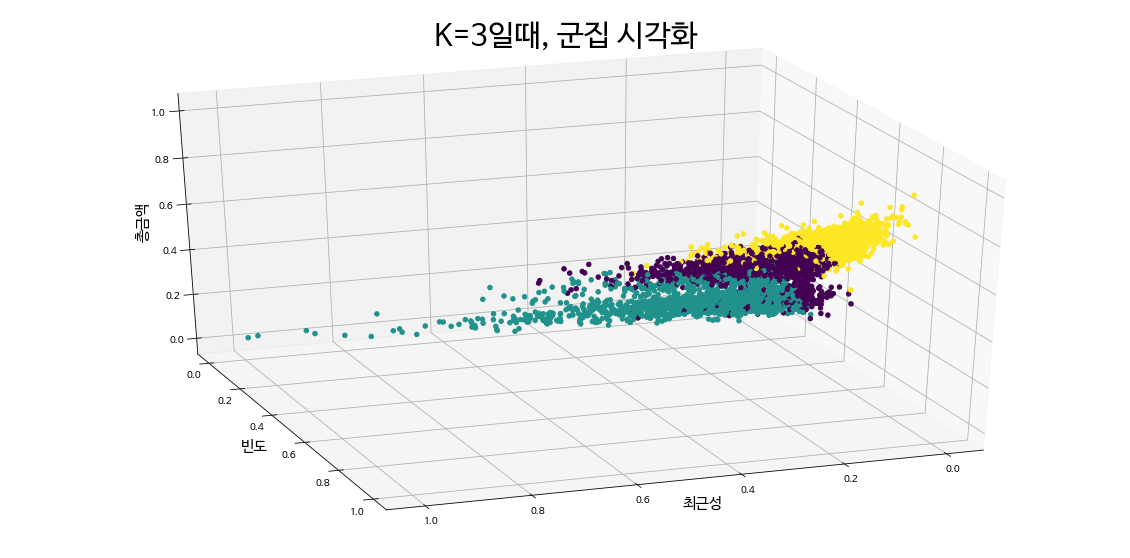

In [58]:
%matplotlib inline
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection = '3d')

x = rfm_clus3['R']
y = rfm_clus3['F']
z = rfm_clus3['M']
h = rfm_clus3['label']

ax.view_init(30, 70)
plt.title('K=3일때, 군집 시각화', fontsize = 30)
ax.set_xlabel('최근성', fontsize = 15)
ax.set_ylabel('빈도', fontsize = 15)
ax.set_zlabel('총금액', fontsize = 15, rotation = 90)
ax.scatter(x, y, z, c = h, marker = 'o', alpha = 1)

## - 실루엣 분석을 실시했을 때, k=2일 때, 가장 분리가 잘된 케이스이기 때문에 2와 3을 시각화하여 보여줌.
## - 시각화를 한 결과, 어느정도 분리가 되어 있는 것을 확인할 수 있음.

In [59]:
rfm2_mean = pd.DataFrame([rfm_clus2.groupby('label').R.mean(), rfm_clus2.groupby('label').F.mean(), rfm_clus2.groupby('label').M.mean()])
rfm3_mean = pd.DataFrame([rfm_clus3.groupby('label').R.mean(), rfm_clus3.groupby('label').F.mean(), rfm_clus3.groupby('label').M.mean()])


In [60]:
rfm2_mean

label,0,1
R,0.121418,0.070340
F,0.278804,0.512101
M,0.220810,0.498637


In [61]:
rfm3_mean

label,0,1,2
R,0.083332,0.138315,0.062079
F,0.404334,0.238362,0.583680
M,0.386417,0.165344,0.567274


# 결론
## 1. K=2로 군집화 했을 때, 0과 1의 라벨링된 고객을 볼 수 있음
## 2. R의 숫자가 적을수록, FM은 큰수록 기업 입장에서 가치가 있는 고객으로 분류될 수 있다.
## 3. 라벨링이 1로 처리된 고객의 경우, R은 낮고 FM은 더 높은 것으로 볼 때, 해당 고객층의 CRM이 매우 중요한 것을 확인할 수 있다.
## 4. 이후, 0과 1의 고객 특성을 파악하여 0의 고객은 자사가 운영하는 서비스로 다시 올 수 있도록 마케팅을 진행하고, 1로 분류된 고객은 객단가를 높이거나 보다 높은 충성 고객으로 만들 수 있는 방법으로 마케팅이 진행되어야 할 것이다.

## 5. k=2와 마찬가지로 K=3으로 분류된 경우, 2 > 0 > 1 순으로 고객 가치가 높다라고 볼 수 있다.
## 6. 하지만, 실루엣 분석 결과 2로 군집화가 되었을 때 가장 분리가 잘되었기 때문에 최적의 군집 모형은 이진 분류 형태로 나타날 수 있다.